In [1]:
import torch
import pandas as pd
import numpy as np

rng = np.random.default_rng()

# Testing CNN Tranformer Model Class

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import os
import glob
import time
from datetime import datetime
import matplotlib.pyplot as plt
import math
import random

import model.hyperparameters as hp
from model.Transformer import TransformerModel
from utils.train import Transformer_train_fn
from utils.dataset import (
    SmartwatchDataset, 
    SmartwatchAugmentTransformer, 
    get_file_lists
)
from utils.utils import test_Transformer

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Try to train the model...

In [3]:

# Paths
SAVE_PATH = Path(f'outputs/{datetime.now().strftime("%d-%m-%Y_%H%M%S")}')

TRAIN = True

if TRAIN == True:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(log_dir=f'{SAVE_PATH}/tensorboard')
    TEST_PATH = SAVE_PATH
else:
    TEST_PATH = Path(input('Enter path to folder containing weights: '))


2023-04-17 02:55:10.494476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-17 02:55:10.494605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-17 02:55:10.494618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
# Get .csv files
train_files, val_files, test_files = get_file_lists(
    val_sub_list=['05', 10, 15, 20, 25, 30],
    test_sub_list=[35],
)

# Get dataloaders
train_dataset = SmartwatchDataset(train_files)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=True)

val_dataset = SmartwatchDataset(val_files)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=True)

test_dataset = SmartwatchDataset(test_files)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=False)



In [5]:
hidden_size = 128
dropout_p = 0.1
kernel_size = 7
num_layers = 2
num_epochs = 5

In [6]:
# Initialize transformer
transformer_model = TransformerModel(
    input_size=9,
    d_model=hidden_size,
    dropout=dropout_p,
    n_heads=int(hidden_size/4),
    stride=2,
    kernel_size=kernel_size,
    seq_len=1024,
    downsample=True,
    output_size=7,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers
).to(hp.DEVICE)

# Initialize loss functions
loss_fn = nn.MSELoss()
metric_loss_fn = nn.L1Loss()

# Initialize optimizers
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=hp.TRANSFORMER_LEARNING_RATE)



In [7]:
val_loss_values = Transformer_train_fn(
        train_loader,
        val_loader,
        transformer_model,
        transformer_optimizer,
        loss_fn,
        metric_loss_fn,
        num_epochs,
        hp.DEVICE,
        SAVE_PATH,
        writer,
        hp.TRANSFORMER_TEACHER_FORCE_RATIO,
        checkpoint=None,
        batch_size=hp.TRANSFORMER_BATCH_SIZE
    )



===== Epoch: 0 =====
Epoch 0 MSE Loss: 0.03555313187340895
Epoch 0 MAE: 0.1446295827627182
===== Epoch: 1 =====
Epoch 1 MSE Loss: 0.014560333918780088
Epoch 1 MAE: 0.0920134112238884
===== Epoch: 2 =====
Epoch 2 MSE Loss: 0.008992912674633166
Epoch 2 MAE: 0.07104372978210449
===== Epoch: 3 =====
Epoch 3 MSE Loss: 0.005779503029771149
Epoch 3 MAE: 0.05574097856879234
===== Epoch: 4 =====
Epoch 4 MSE Loss: 0.004172820287446181
Epoch 4 MAE: 0.04744591563940048


ValueError: x and y must have same first dimension, but have shapes (512,) and (1024,)

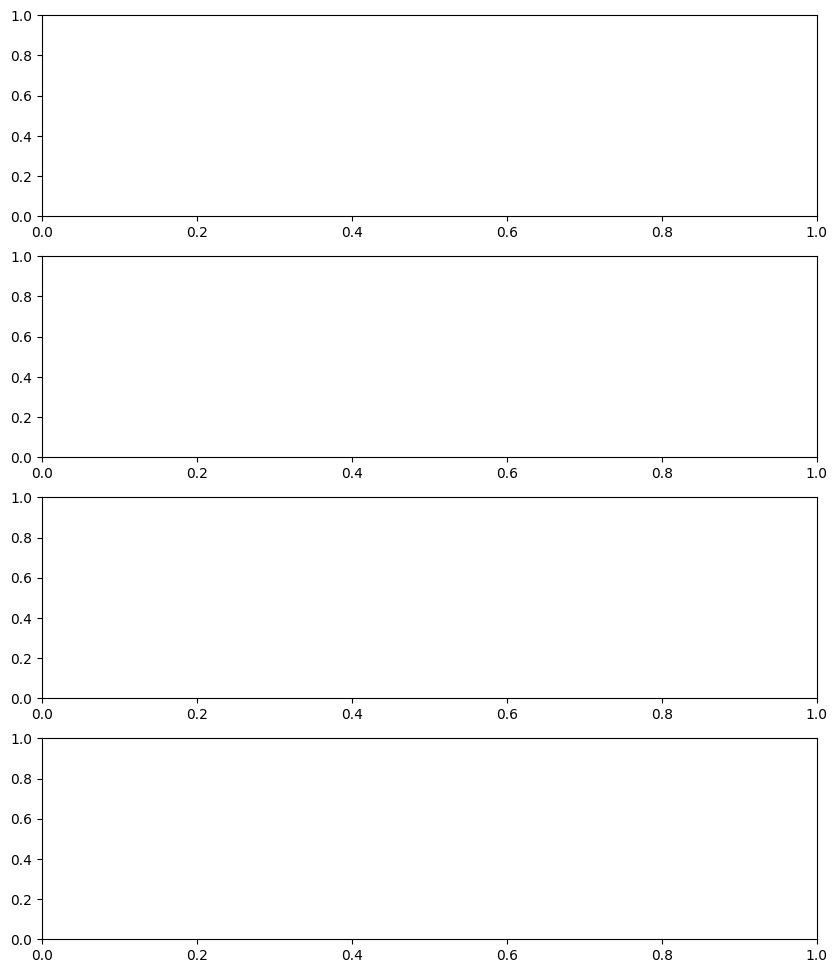

In [8]:
test_Transformer(
    test_loader,
    transformer_model,
    loss_fn,
    metric_loss_fn,
    SAVE_PATH,
    hp.DEVICE,
)


In [ ]:
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
print(pytorch_trainable_params)

1160007
1160007
